In [1]:
# auto reload modules
%load_ext autoreload
%autoreload 2

import warnings
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as tkr
import matplotlib.gridspec as gridspec
from sys import platform
from xanimations import Movie
from IPython.display import HTML, display
from matplotlib.colors import LinearSegmentedColormap, CenteredNorm, BoundaryNorm
from viztool import FormatScalarFormatter
from dask.distributed import LocalCluster, Client

In [2]:
%matplotlib inline
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['axes.labelsize'] = 8

###patch start###
from mpl_toolkits.mplot3d.axis3d import Axis
if not hasattr(Axis, "_get_coord_info_old"):
    def _get_coord_info_new(self, renderer):
        mins, maxs, centers, deltas, tc, highs = self._get_coord_info_old(renderer)
        mins += deltas / 4
        maxs -= deltas / 4
        return mins, maxs, centers, deltas, tc, highs
    Axis._get_coord_info_old = Axis._get_coord_info  
    Axis._get_coord_info = _get_coord_info_new
###patch end###

In [3]:
dsf = xr.open_dataset('/glade/derecho/scratch/zhihuaz/FrontalZone/Output/f11_Q000_W000_D000_St0_full.nc').chunk({'time':1})
dsf.close()
dsf['timeTf'] = dsf.time/np.timedelta64(int(np.around(2*np.pi/dsf.f)), 's')
dsf

<xarray.Dataset> Size: 297GB
Dimensions:  (zC: 64, zF: 65, xC: 512, yF: 512, xF: 512, yC: 512, time: 315)
Coordinates:
  * zC       (zC) float64 512B -138.3 -134.8 -131.3 ... -4.392 -2.635 -0.8781
  * zF       (zF) float64 520B -140.0 -136.5 -133.0 -129.6 ... -3.513 -1.756 0.0
  * xC       (xC) float64 4kB -499.0 -497.1 -495.1 -493.2 ... 495.1 497.1 499.0
  * yF       (yF) float64 4kB 0.0 1.953 3.906 5.859 ... 992.2 994.1 996.1 998.0
  * xF       (xF) float64 4kB -500.0 -498.0 -496.1 -494.1 ... 494.1 496.1 498.0
  * yC       (yC) float64 4kB 0.9766 2.93 4.883 6.836 ... 995.1 997.1 999.0
  * time     (time) timedelta64[ns] 3kB 4 days 08:44:16.975075488 ... 6 days ...
Data variables:
    v        (time, zC, yC, xC) float64 42GB dask.array<chunksize=(1, 64, 512, 512), meta=np.ndarray>
    eps      (time, zC, yC, xC) float64 42GB dask.array<chunksize=(1, 64, 512, 512), meta=np.ndarray>
    w        (time, zC, yC, xC) float64 42GB dask.array<chunksize=(1, 64, 512, 512), meta=np.ndarray>
    c        (time, zC, yC, xC) float64 42GB dask.array<chunksize=(1, 64, 512, 512), meta=np.ndarray>
    b        (time, zC, yC, xC) float64 42GB dask.array<chunksize=(1, 64, 512, 512), meta=np.ndarray>
    u        (time, zC, yC, xC) float64 42GB dask.array<chunksize=(1, 64, 512, 512), meta=np.ndarray>
    PV       (time, zF, yF, xF) float64 43GB dask.array<chunksize=(1, 65, 512, 512), meta=np.ndarray>
    timeTf   (time) float64 3kB 6.001 6.006 6.016 6.026 ... 8.976 8.986 8.995
Attributes:
    f:                     0.0001
    Dˢ:                    1
    viscosity_mol:         1e-06
    schedule:              TimeInterval
    interval:              600.0
    Julia:                 This file was generated using Julia Version 1.9.3\...
    output time interval:  Output was saved every 10 minutes.
    Uˢ:                    0
    date:                  This file was generated on 2024-03-22T07:31:58.575.
    diffusivity_mol:       1.5e-07
    M²:                    3e-08
    Oceananigans:          This file was generated using Oceananigans v0.90.7

In [116]:
def custom_plotfunc(dsf, fig, itime, *args, **kwargs):
    cname = kwargs['cname']
    vname = kwargs['vname']
    var_sel = [vname, 'b']

    if vname == 'PV':
        cmap = 'RdBu_r'
        cticks = np.arange(-2e-10,3e-10,1e-10)
        clabel_pad = -50
        vmin, vmax = -2.5e-10, 2.5e-10
        var_label = r'Ertel PV'
        var_extend = 'both'
        sci_notation = True
        var_plt = 'PV'
        coords = 'F'
    else:
        coords = 'C'
        if vname == 'b':
            colorlist = ['xkcd:navy', 'xkcd:cerulean', 'xkcd:sky', 'xkcd:white', 'xkcd:coral', 'xkcd:deep red']
            nodes = [0.0, 0.7, 0.78, 0.82, 0.9, 1.0]
            cmap = LinearSegmentedColormap.from_list('buoyancy', list(zip(nodes, colorlist)))
            cticks = np.arange(0,2,0.2)*1e-4
            clabel_pad = -45
            vmin, vmax = -2e-5, 1.9e-4
            var_label = r'Buoyancy [m s$^{-2}$]'
            var_extend = 'max'
            sci_notation = True
            var_plt = 'bt'
        elif vname == 'c':
            # top['logc']   =   np.log10(top.c.clip(1e-6,1)).squeeze().transpose('yC','xC',...)
            # south['logc'] = np.log10(south.c.clip(1e-6,1)).squeeze().transpose('xC','zC',...)
            # east['logc']  =  np.log10(east.c.clip(1e-6,1)).squeeze().transpose('yC','zC',...)
            cmap = 'ocean_r'
            cticks = np.arange(0,1.2,0.2)#np.arange(-2,0.5,0.5)
            clabel_pad = -45#-50
            vmin, vmax = 0, 1#-2, 0
            var_label = 'c'#r'$\log_{10}(c)$'
            var_extend = 'max'#'min'
            sci_notation = False
            var_plt = 'c'#'logc'
        elif vname == 'u':
            cmap = 'RdBu_r'
            cticks = np.arange(-0.03,0.04,0.01)
            clabel_pad = -50
            vmin, vmax = -0.038, 0.038
            var_label = r'u [m s$^{-1}$]'
            var_extend = 'both'
            sci_notation = True
            var_plt = 'u'
        elif vname == 'eps':
            cmap = 'Reds'
            cticks = np.arange(-9,-6,1)
            clabel_pad = -50
            vmin, vmax = -9, -7
            var_label = r'Dissipation rate $\log_{10}(\epsilon)$'
            var_extend = 'min'
            sci_notation = False
            var_plt = 'logeps'

    frame_time = dsf.timeTf.isel(time=itime)
    top = dsf[var_sel].sel(zC=[-8], method='nearest').isel(time=itime)
    z_top_slice = top.zC[0]
    south = dsf[var_sel].isel(yC=[0]).sel(zC=slice(None,z_top_slice)).isel(time=itime)
    y_south_slice = south.yC[0]
    east = dsf[var_sel].isel(xC=[-1]).sel(zC=slice(None,z_top_slice)).isel(time=itime)
    x_east_slice = east.xC[0]
    X, Y, Z = np.meshgrid(top.xC, top.yC, east.zC)

    if coords == 'F':
        top = top.sel(zF=[-8], method='nearest')
        zF_top_slice = top.zF[0]
        south = south.isel(yF=[0]).sel(zF=slice(None,zF_top_slice))
        yF_south_slice = south.yF[0]
        east = east.isel(xF=[-1]).sel(zF=slice(None,zF_top_slice))
        xF_east_slice = east.xF[0]
        XF, YF, ZF = np.meshgrid(top.xF, top.yF, east.zF)

    # total buoyancy
    top['bt']   = (-dsf.attrs['M²'] * dsf.xC +   top.b).squeeze().transpose('yC','xC',...)
    south['bt'] = (-dsf.attrs['M²'] * dsf.xC + south.b).squeeze().transpose('xC','zC',...)
    east['bt']  = (-dsf.attrs['M²'] * dsf.xC +  east.b).squeeze().transpose('yC','zC',...)

    if vname == 'eps':    
        varT =   np.log10(top.eps).squeeze().transpose('yC','xC',...)
        varS = np.log10(south.eps).squeeze().transpose('xC','zC',...)
        varE =  np.log10(east.eps).squeeze().transpose('yC','zC',...)
    else:
        varT =   top[var_plt].squeeze().transpose(f'y{coords}',f'x{coords}',...)
        varS = south[var_plt].squeeze().transpose(f'x{coords}',f'z{coords}',...)
        varE =  east[var_plt].squeeze().transpose(f'y{coords}',f'z{coords}',...)

    # surface wind
    taum = int(cname[10:13])/1e3
    taud = int(cname[15:18])
    if cname[14] == 'O':
        temporal_wind = np.sin(2*np.pi*np.maximum((frame_time - 6), 0))
    else:
        cos_ramp = (1 - np.cos(np.pi*np.maximum((frame_time - 6), 0) / np.sqrt(2))) / 2
        if frame_time < (6+np.sqrt(2)):
            temporal_wind = cos_ramp
        else:
            temporal_wind = 1
    taux = np.cos(taud/180*np.pi)*taum*temporal_wind
    tauy = np.sin(taud/180*np.pi)*taum*temporal_wind

    # limits and contour values
    blines = np.concatenate([np.arange(0,1.4,0.2), np.arange(1.3,2.6,0.04)])*1e-4
    xmin, xmax = -500, 500
    ymin, ymax = 0, 1000
    zmin, zmax = -140, z_top_slice.data
    
    Ckw = {'vmin': vmin,
           'vmax': vmax,
           'extend': var_extend,
           'levels': np.linspace(vmin, vmax, 256*2),
           'cmap': cmap
          }
    Lkw = {'linewidths': 0.2,
           'colors': 'xkcd:almost black'
          }
    Lkwt = {'linewidths': 0.05,
            'colors': 'xkcd:almost black'
           }
    edges_kw = {'color': 'xkcd:charcoal',
                'linewidth': 1,
                'zorder': 2
               }
    
    ax = fig.add_subplot(111, projection='3d', computed_zorder=False)
    xroll = 0

    if coords == 'F':
        Ct = ax.contourf(XF[:, :, -1], YF[:, :, -1], varT.roll(xF=xroll), zdir='z', offset=zF_top_slice, **Ckw)
        Cs = ax.contourf(XF[0, :, :], varS.roll(xF=xroll), ZF[0, :, :], zdir='y', offset=yF_south_slice, **Ckw)
        Ce = ax.contourf(varE, YF[:, -1, :], ZF[:, -1, :], zdir='x', offset=xF_east_slice, **Ckw)
    else:
        Ct = ax.contourf(X[:, :, -1], Y[:, :, -1], varT.roll(xC=xroll), zdir='z', offset=z_top_slice, **Ckw)
        Cs = ax.contourf(X[0, :, :], varS.roll(xC=xroll), Z[0, :, :], zdir='y', offset=y_south_slice, **Ckw)
        Ce = ax.contourf(varE, Y[:, -1, :], Z[:, -1, :], zdir='x', offset=x_east_slice, **Ckw)
    
    Lt = ax.contour(X[:, :, -1], Y[:, :, -1], top.bt.roll(xC=xroll), blines, zdir='z', offset=z_top_slice, **Lkwt)
    Ls = ax.contour(X[0, :, :], south.bt.roll(xC=xroll), Z[0, :, :], blines, zdir='y', offset=y_south_slice, **Lkw)
    Le = ax.contour(east.bt, Y[:, -1, :], Z[:, -1, :], blines, zdir='x', offset=x_east_slice, **Lkw)
    Aw = ax.quiver(300, 1000, 10, 6e3*taux, 6e3*tauy, 0, normalize=False, colors='k',
                   arrow_length_ratio=0.2, lw=3, capstyle='round', joinstyle='round')
    
    ax.plot([xmax, xmax], [ymin, ymax], zmin, **edges_kw)
    ax.plot([xmin, xmax], [ymin, ymin], zmin, **edges_kw)
    ax.plot([xmax, xmax], [ymin, ymax], zmax, **edges_kw)
    ax.plot([xmin, xmax], [ymin, ymin], zmax, **edges_kw)
    ax.plot([xmin, xmin], [ymin, ymax], zmax, **edges_kw)
    ax.plot([xmin, xmax], [ymax, ymax], zmax, **edges_kw)
    ax.plot([xmax, xmax], [ymax, ymax], [zmin, zmax], **edges_kw)
    ax.plot([xmax, xmax], [ymin, ymin], [zmin, zmax], **edges_kw)
    ax.plot([xmin, xmin], [ymin, ymin], [zmin, zmax], **edges_kw)
    ax.set(xlabel='X [m]',
           ylabel='Y [m]',
           zlabel='Z [m]',
           zticks=[-10, -60, -120],
           xticks=[-400, -200, 0, 200, 400],
           yticks=[100, 300, 500, 700, 900],
           xlim=[xmin, xmax], 
           ylim=[ymin, ymax], 
           zlim=[zmin, zmax])
    ax.tick_params(axis='both', labelsize=8)
    ax.view_init(45, -70, 0)
    ax.set_box_aspect((1,1,0.55), zoom=1.1)
    ax.set_title(rf'$T_{{inertial}}$ = {frame_time:.2f}', y=0.999, x=0.6, fontsize=10)
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.xaxis.pane.set_edgecolor('w')
    ax.yaxis.pane.set_edgecolor('w')
    ax.zaxis.pane.set_edgecolor('w')
    ax.grid(False)
    
    cbar = fig.colorbar(Ct, ax=ax, fraction=0.02, pad=0.1, ticks=cticks, 
                        format=FormatScalarFormatter('%.1f'))
    cbar.set_label(var_label, labelpad=clabel_pad, fontsize=10)
    if sci_notation:
        cbar.formatter.set_powerlimits((0, 0))
        cbar.formatter.set_useMathText(True)
        cbar.ax.get_yaxis().get_offset_text().set_visible(False)
        exponent_axis = np.floor(np.log10(max(cbar.ax.get_yticks()))).astype(int)
        cbar.ax.annotate(r'$\times$10$^{%i}$'%(exponent_axis), fontsize=8,
                         xy=(-0.2, 1.08), xycoords='axes fraction')
    cbar.ax.tick_params(labelsize=8)
    return None, None

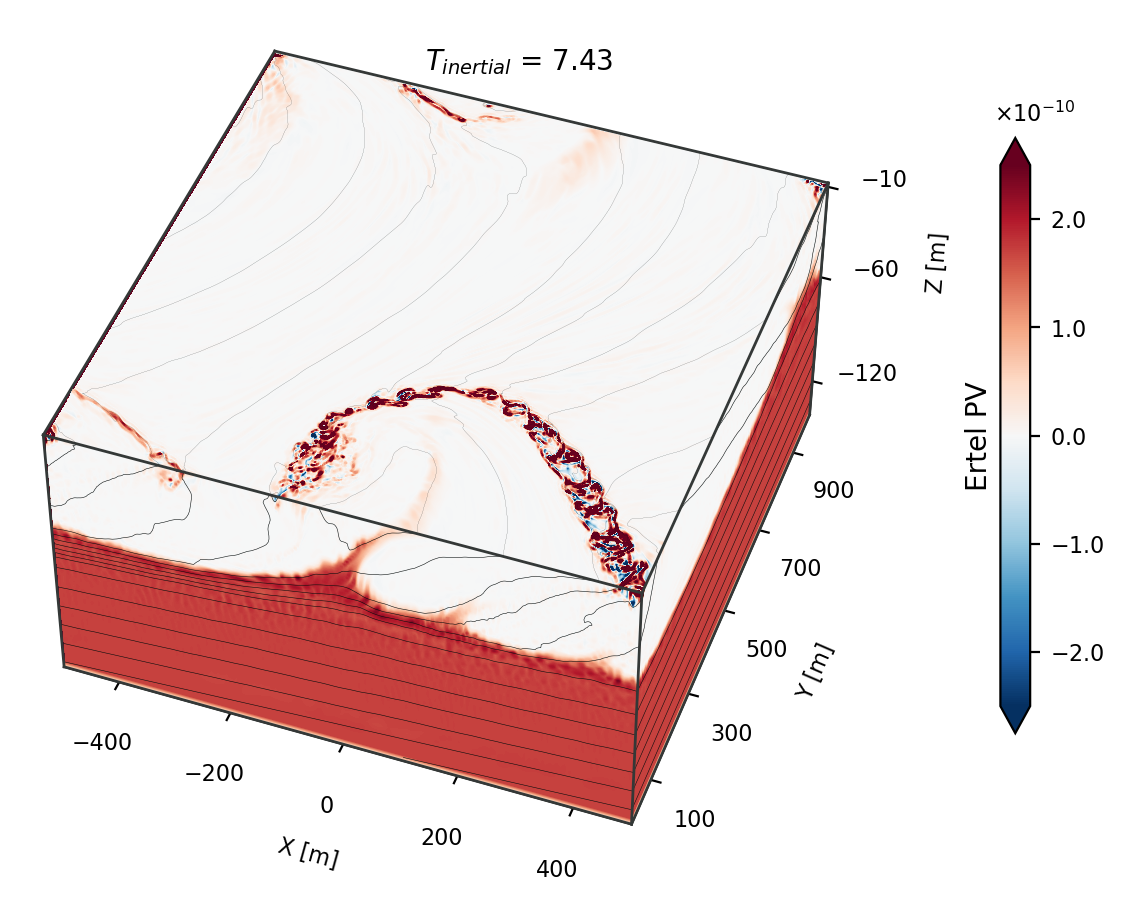

In [117]:
mov_custom = Movie(dsf, custom_plotfunc, input_check=False, cname='f11_Q000_W000_D000_St0', vname='PV')
mov_custom.preview(150)

In [ ]:
%%time
mov_custom.save(
    'f11_Q000_W000_D000_St0_bt3d.mp4',
    parallel=True,
    overwrite_existing=True,
    parallel_compute_kwargs=dict(scheduler='processes', num_workers=8)
)